# "[SSUDA] 영화 데이터를 활용한 추천시스템 실습
- author: Seong Yeon Kim 
- categories: [SSUDA, jupyter, Deep Learning, matrix, SVD, Recommended system, kaggle]

# 추천시스템

단순하게 떠올릴 수 있는 영화추천시스템은 3가지가 있습니다.

1) 보편적으로 많은 사람이 좋아하는 영화를 추천합니다. 가장 단순하고 강력한 방법입니다만 개인별 추천시스템과는 거리가 있습니다.

2) 특정 항목 내 비슷한 내용이 있는 영화를 추천합니다. 영화의 장르, 감독, 설명, 배우 등을 고려합니다. 어떤 사람이 특정 영화를 좋아한다면 비슷한 성격의 영화도 좋아할 것이다라는 논리 입니다.

3) 관심사가 비슷한 사용자를 매칭시키고 매칭된 사용자를 참고해 영화를 추천합니다.

# 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

path = '/content/drive/MyDrive/movie/'

df1=pd.read_csv(path + 'tmdb_5000_credits.csv')
df2=pd.read_csv(path + 'tmdb_5000_movies.csv')

df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


데이터를 불러옵니다.

# 1) 보편적으로 최고의 영화 추천하기

기술이 고도화됨에 따라 개인별 맞춤 추천 시스템을 많이 주목하지만 보편적으로 최고인 영화를 과소평가해선 안됩니다. 

두 가지 모두 고려해야 더 좋은 효과를 보일 수 있습니다.

최고의 영화를 판별하는 기준만 정한다면 쉽게 구할 수 있습니다. 

단순히 평점을 기준으로 한다면 소규모 평가가 이루워진 영화가 고평가 될 수 있습니다.

그래서 다음과 같은 기준을 사용합니다.

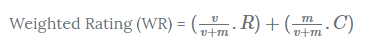

v는 평가한 인원의 수, m은 차트에 기록되기 위한 최소 평가 인원수

R은 영화의 평점, C는 모든 영화 평점의 평균 입니다.

직관적으로 식을 해석해보면 평가한 인원이 많다면(V가 크다면) 영화의 평점 영향력을 크게하겠다 입니다.

In [3]:
C= df2['vote_average'].mean()
C

6.092171559442016

모든 영화의 평점의 평균은 10점만점에 6점정도 되네요.

In [4]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [5]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

보편적으로 최고의 영화다라고 판별하기 위해서는 최소한 영화 평가가 어느정도 있는 영화를 대상으로 판별해야합니다.

평가 개수가 상위 10%인 영화만(481개) 선별합니다.

In [6]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']

    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

앞서 설명한 가중치를 이용해 영화를 평가하는 기준 값을 apply 함수를 사용해 구합니다.

In [7]:
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


In [8]:
q_movies = q_movies.sort_values('vote_average', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
3337,The Godfather,5893,8.4,7.851236
1818,Schindler's List,4329,8.3,7.641883
2731,The Godfather: Part II,3338,8.3,7.515889
662,Fight Club,9413,8.3,7.939256
3865,Whiplash,4254,8.3,7.633781
2294,Spirited Away,3840,8.3,7.585209
3232,Pulp Fiction,8428,8.3,7.904645
809,Forrest Gump,7927,8.2,7.803188
3057,American History X,3016,8.2,7.401749


윗 코드는 새로운 지표 기준 상위 10개 영화, 밑 코드는 단순한 평점 기준 상위 10개 영화입니다. 1등을 제외하고 지표가 다릅니다.

이러한 보편적으로 최고의 영화를 추천하는 방식은 특정 사용자의 흥미나 취향에 민감하지 않다는 단점이 있습니다.

# 2) 내용 기반 영화 추천하기

In [9]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

유사한 overview을 가진 영화를 추천하는 모델을 만들어보겠습니다. 그러기 위해선 overview 내 언어를 숫자로 변환해야하는데요.

영어 기준으로 단어 단위로 나오는 횟수를 단순히 원핫인코딩 방식으로 기록하는 CountVectorizer 함수를 고려할 수 있습니다.

CountVectorizer 은 입력받은 모든 단어를 단어사전에 기록하고 원핫인코딩 방식으로 각 문장을 숫자로 반환해줍니다.

다만 관계대명사 등 자주 나오는 단어이나 영화 내용을 파악하는데 불필요한 단어가 많이 기록된다는 단점이 있는데요.

이를 보안한 것이 TfidfVectorizer 입니다.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

df2['overview'] = df2['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df2['overview'])

print(tfidf_matrix[1].toarray())
print(tfidf_matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]]
(4803, 20978)


TfidfVectorizer 의 토대가 되는 기호 정리부터 하겠습니다.

TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수.

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수.

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

다른 문장에 많이 나오지 않는 단어는 고유한 그 영화만에 특성을 가진 단어라고 볼 수 있고 TF-IDF은 이를 반영한 지표입니다.

약 4800개 영화에 21000개 정도 단어종류가 확인됬군요.

In [19]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim.shape)

(4803, 4803)


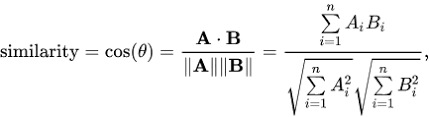

단어집합의 유사도 검정을 할 때 코사인 유사도 값을 많이 사용합니다.

cosine_sim 은 각각의 영화별 코사인 유사도 값을 기록한 행렬값 입니다.

In [21]:
# indices : 영화 제목마다 인덱스를 달아줌. 제목을 넣으면 인덱스 값이 나옴.
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    # 입력받은 영화 제목의 인덱스 추출
    idx = indices[title]

    # 입력받은 영화와 다른 모든 영화의 코사인 유사도를 행렬에서 추출함.
    # enumerate로 인덱스를 붙히고 리스트로 변환함.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 코사인 유사도가 높은 순서대로 정렬함.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 코사인 유사도가 높은 상위 10개 영화를 추출. 이때 인덱스 값이 같이 추출됨.
    sim_scores = sim_scores[1:11]

    # 코사인 유사도가 높은 상위 10개 영화의 인덱스만 추출
    movie_indices = [i[0] for i in sim_scores]

    # 인덱스를 이용해 영화 제목 추출.
    return df2['title'].iloc[movie_indices]

In [22]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [23]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

영화 제목 입력받으면 그와 비슷한(코사인 유사도기반) overview를 가진 상위 10개 영화를 추출하는 함수를 제작했습니다.

# 3) 관심사가 비슷한 사용자로 영화 추천하기

In [33]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


surprise는 다양한 추천시스템 함수를 가진 패키지 입니다.

In [36]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
ratings = pd.read_csv(path +'ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


surprise 패키지 내 SVD 함수를 이용하기 위해선 데이터 프레임이 반드시 (사용자ID, 영화ID, 평점) 순으로 있어야합니다.

In [40]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()

cross_validate(svd, data, measures=['RMSE'], cv=5)

{'fit_time': (8.233148574829102,
  5.2691779136657715,
  5.370789527893066,
  5.306999921798706,
  5.467830181121826),
 'test_mae': array([0.68962625, 0.69583257, 0.68883765, 0.69072012, 0.69067091]),
 'test_rmse': array([0.89545545, 0.89963625, 0.8925816 , 0.89423993, 0.90127922]),
 'test_time': (0.15677785873413086,
  0.14635586738586426,
  0.15284276008605957,
  0.15076279640197754,
  0.14911937713623047)}

RMSE 값이 크진 않은 것 같습니다.

In [43]:
svd.predict(1, 1172, 3)

Prediction(uid=1, iid=1172, r_ui=3, est=3.423968547182108, details={'was_impossible': False})

In [44]:
ratings[(ratings['userId'] == 1) & (ratings['movieId'] == 1172)]

,userId,movieId,rating,timestamp
4,1,1172,4.0,1260759205


예측값과 실제값의 일부 사례를 관찰해보았습니다.

# 출처

데이터

https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

코드

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

참고자료

https://wiserloner.tistory.com/917

https://seing.tistory.com/67